In [1]:
#Importações
import numpy as np
import numpy.random as npr
from sklearn import datasets
import pandas as pd
import copy
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (15,8)
import seaborn as sns; sns.set(color_codes=True)
import csv
import math

In [2]:
#Individuo
#1. Criar os genes. 
# --> createGenes: Cria os genes aleatoriamente (1ª utilização)
# --> crossoverGenesAndTestMutation: Cria os Genes atraves do Cruzamento entre os pais

#2. Mutação nos genes (Exatamente após o item 1).
# --> probably: Calcula a chance de ocorre algo, retornado sem ou não a esta chance 
# --> testMutationGenes: Calcula a Chance de mutação e a mutação em si
# [Mutação troca dois cromossomos de lugar, mutação somente a partir da 2ª geração]

#3. Calcular e guardar o fitness (Somente após o item 1 e 2).
# --> denormalizationGenes: Desnormaliza os valores do Genes antes de calcular
# --> calcFitness: Calcula o Fitness

#4. Seleção do indívíduo mais apto (Somente após o item 1, 2 e 3)
# --> selection: Retorna o vencedor
# [Seleção por Torneio - dois individuos, vence o melhor fitness]

class Individuo():    
    gene            = []            #Cromossomos Base/Original
    ind             = []            #Cromossomos 
    fitness         = 0.0           #Pontuação do Individuo
    #---------------
    maxGeneValue    = 5.12  #Maior valor para Desnormalização
    minGeneValue    = -5.12  #Menor valor para Desnormalização
    #---------------
    maxValueNorm    = 1.0           #Maior valor para Normalizar
    minValueNorm    = 0.0           #Menor valor para Normalizar
    maxChromosome   = 2             #Quantidade maxima de cromossomos
    chanceMutation  = 0.01          #Chance de Mutação (0.01 = 1%)

    #Inicializa os atributos do Individuo
    def __init__(self):
        pass
    
    #Após a criação dos Genes e a estruturação dos cromossomos, aplica a chance de mutação nos mesmos
    def testMutationGenes(self):
        #Verifica se vai ocorrer mutação
        if self.probably(self.chanceMutation):
            #Troca de lugar os valores.
            first = self.gene[0]
            second = self.gene[1]
            self.gene[0] = second
            self.gene[1] = first
    
    #Calcula a chance de algo ocorrer (Ex.: 0.14 é 14% de ocorrer algo)
    def probably(self, chance):
        return npr.random() <= chance

    #Cria os Genes do zero, Usando uma distribuição uniforme (sequências de números reais normalizados entre 0 a 1).
    def createGenes(self):
        self.gene = []
        self.gene = np.random.uniform(self.minValueNorm, self.maxValueNorm, self.maxChromosome)
    
    #Cruzamento (50% dos genes do pai e 50% dos genes da mãe)
    #cross...(pai, mae) e cross...(mae, pai) = gera 2 filhos com as metades dos pais.
    def crossoverGenesAndTestMutation(self, parentChromosome1, parentChromosome2):
        self.gene = []        
        halfChromosome = math.floor(self.maxChromosome/2)
        for i in range(0, halfChromosome):
            self.gene.append(parentChromosome1.gene[i])
        for i in range(halfChromosome, self.maxChromosome): 
            self.gene.append(parentChromosome2.gene[i])
        self.testMutationGenes()

    #Desnormalização os valores dos genes
    # Equação 1 (Desnormaliza de 0 e 1 para outra faixa) | x = min + (max-min) * value
    def denormalizationGenes(self):
        self.ind = []
        for i in range(0, self.maxChromosome):
            self.ind.append(self.minGeneValue + (self.maxGeneValue-self.minGeneValue) * self.gene[i])
   
    #Função objetivo para minimização
    def calcFitness(self):
        self.denormalizationGenes()
        indDecod = self.ind
        self.fitness = 10*len(indDecod)
        for i in range(len(indDecod)):
            self.fitness += indDecod[i]**2 - (10*math.cos(2*math.pi*indDecod[i]))   
        
    #Competição entre dois individuos, vence o maior fitness
    def selection(self, rival):
        if self.fitness <= rival.fitness:
            return copy.deepcopy(self)
        else:
            return copy.deepcopy(rival)

    def printChromossome(self):
        print(self.gene, self.fitness)

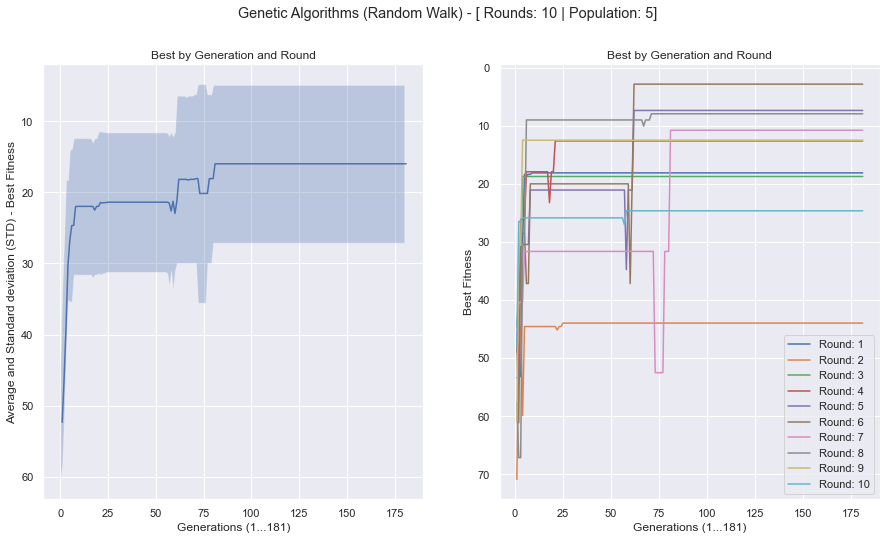

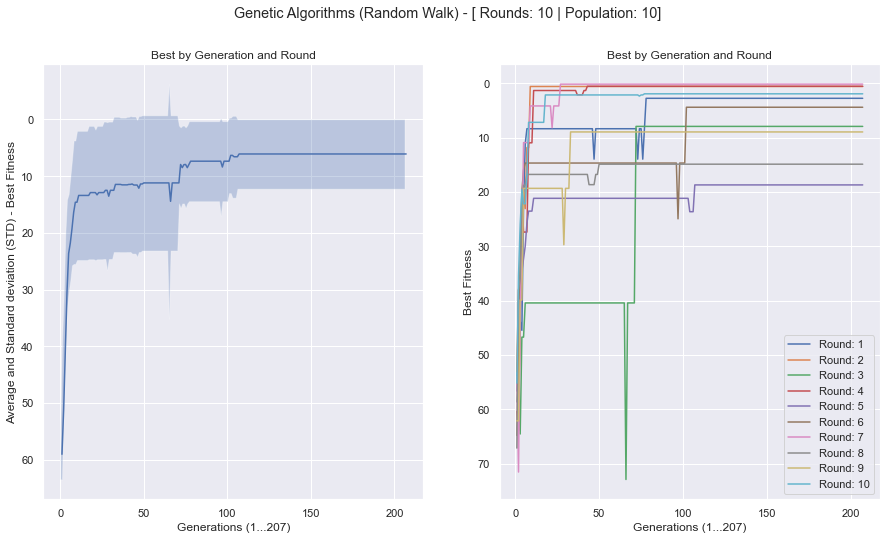

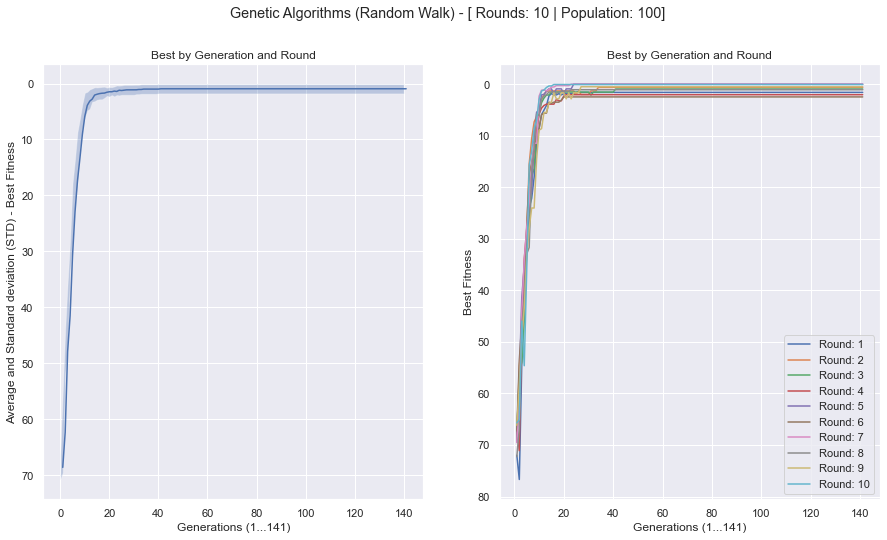

In [3]:
#Populacao
#* Seleção: roleta, torneio, classificação/ranking, truncamento
#* Reprodução: acasalamento, recombinação e mutação

class Populacao():
    
    #---------
    population              =   []      #Conjunto de Individuos de uma geração
    sizePopulation          =   100     #Total de individuos na população
    bestIndGeneration       =   []      #Melhor individuo de cada Geração
    bestIndividuo           =   None    #Guarda o ULTIMO melhor individuo da geração
    countNoEvolution        =   0       #Contador de fitness que não evolui (count_stagnation)
    limitNoEvolution        =   100     #Limite maximo de fitness que não evolui (Limite K)
    evolution               =   0.01    #Se por K gerações a qualidade da solução ficou abaixo de um delta (= 0.01, por exemplo), então o algoritmo alcançou sua condição de parada.
    chanceCrossover         =   0.5     #Chance dos pais cruzarem, caso contrario seus genes vão  na integra para a proxima geração
    #---------
    listGenerations         =   []      #Matriz de "bestIndGeneration" (Guarda os dados gerais da geração e melhores individuos)
    meanBestFitness         =   []      #Média das Gerações guardadas em "listGenerations"
    stdBestFitness          =   []      #Desvio Padrão das Gerações guardadas em "listGenerations"
    rounds                  =   10      #Maximo de Rodadas (1 Rodada tem N gerações)    
    #----------
    numMaxGenerations       =   []      #só guarda os numeros das gerações 0 a N para o plot no grafico
   
    #Cria a 1ª população (Inicial)
    def createInitialPopulation(self):
        size = self.sizePopulation - len(self.population)
        for i in range(size):
            novoIndividuo = Individuo()
            novoIndividuo.createGenes()
            #Não precisa aplicar mutação na 1ª geração
            novoIndividuo.calcFitness()
            self.population.append(novoIndividuo)

    #Calcula a chance de algo ocorrer (Ex.: 0.14 é 14% de ocorrer algo)
    def probably(self, chance):
        return npr.random() <= chance

    def selectionReproduction(self):        
        parentsNewGenerations = []
        halfSizePop =  math.floor(len(self.population)/2)

        for i in range(halfSizePop):                                #Só para até criar a nova população
            parentsWin = []                                         #Individuos vencedores do Torneio

            # == Seleção (Torneio/Tournament) ==
            #Pega dois pra competir 2x, resultando um casal
            for t in range(0,2):                                    
                parents = npr.choice(self.population,2)             #Seleciona aleatoriamente dois individuos         
                parentsWin.append(parents[0].selection(parents[1])) #Torneio: O de melhor fitness vence

            # == Cruzamento == 
            # Testa se vai haver Cruzamento de Genes ou repetição
            if self.probably(self.chanceCrossover)==True:
                #Cruzamento: Acasalamento
                novoIndividuoA = Individuo()
                novoIndividuoB = Individuo()

                #Cruzamento: Recombinação e mutação
                novoIndividuoA.crossoverGenesAndTestMutation(parentsWin[0], parentsWin[1])
                novoIndividuoA.calcFitness()
                
                novoIndividuoB.crossoverGenesAndTestMutation(parentsWin[1], parentsWin[0])
                novoIndividuoB.calcFitness()
                
                #Salva os novos individuos
                parentsNewGenerations.append(novoIndividuoA)
                parentsNewGenerations.append(novoIndividuoB)
            
            #Os Genes dos pais passam para geração seguinte na integra
            else:        
                #Salva os novos individuos                                                   
                parentsNewGenerations.append(parentsWin[0])
                parentsNewGenerations.append(parentsWin[1])
        #Atualiza a nova população
        self.population = parentsNewGenerations

    def runPopulation(self, maxRounds, sizePop):
        self.sizePopulation         = sizePop
        self.rounds                 = maxRounds
        self.listGenerations        =  []
        self.meanBestFitness        =  []
        self.stdBestFitness         =  []
        self.numMaxGenerations      =  []

        
        #N Rodadas.
        for i in range(0, self.rounds): 
            self.population         =   []
            self.bestIndGeneration  =   []
            self.bestIndividuo      =   None
            self.countNoEvolution   =   0

            #N Gerações até que o maximo de gerações sem mudança seja atingido.
            while(True):

                if (self.bestIndividuo == None):
                   #Cria a população Inicial
                   self.createInitialPopulation()
                else:
                    #Atualiza a população [Aplica Seleção e Reprodução (Cruzamento e Mutação)]
                    self.selectionReproduction()

                #-------------------
                #Guarda o melhor Individuo
                self.orderPopByFitness()
                currentBestIndividuo = self.population[0]
                
                #Gerencia aquantidade de gerações sem mudanças.
                if (self.bestIndividuo != None):
                    var_fitness = abs(currentBestIndividuo.fitness-self.bestIndividuo.fitness)/self.bestIndividuo.fitness
                    if var_fitness < self.evolution:
                        self.countNoEvolution += 1
                    else:
                        self.countNoEvolution = 0

                #Pega o melhor individuo e Guarda pra geração seguinte
                self.bestIndividuo = currentBestIndividuo

                #Guarda o melhor individuo desta geração/Rodada
                if (self.bestIndividuo != None): 
                    self.bestIndGeneration.append(self.bestIndividuo)

                #Verifica se chegamos na ultima geração
                if self.countNoEvolution == self.limitNoEvolution:
                    break

            #Guarda esta geração de melhores individuos na lista.
            self.listGenerations.append(self.bestIndGeneration)
        
        self.normalizaArrays(self.listGenerations)
        self.meanStdGenerations()

    #Deixa todas as lista do mesmo tamanho (Repetindo o ultimo individuo), 
    #em uma matriz multidimensional ou lista que guarda outras listas
    def normalizaArrays(self, matriz):
        maior = 0
        #Descobre qual o comprimento maximo da lista
        for array in matriz:
            if (len(array) > maior):
                maior = len(array)        
        #Repete o ultimo elemento até atingir o tamanho correto.
        for array in matriz:
            while(len(array) < maior):
                array.append(array[-1])
        return matriz

    #Calcula a média e desvio padrão das gerações
    def meanStdGenerations(self):
        for listInd in zip(*self.listGenerations): #[ [ind1, ind2] [ind3, ind4, ind5] ]
            fits = []
            for ind in listInd: #[2,2]
                fits.append(ind.fitness)
            meanFitsGen = np.mean(fits)
            self.meanBestFitness.append(round(meanFitsGen,3)) 
            self.stdBestFitness.append(round(np.std(fits), 3))

        for i in range(0, len(self.meanBestFitness)):
            self.numMaxGenerations.append(i+1)

    #Ordena os individuos da população pelo seu fitness
    def orderPopByFitness(self):
        self.population.sort(key=lambda ind: ind.fitness, reverse=True) 

    def bestFitnessByRound(self, round):
        teste = []
        for i in self.listGenerations[round]:
            teste.append(i.fitness)
        return teste

    def bestFitnessByRoundAndGen(self):
        listRoundFits = []
        fieldNames = []
        for listInd in zip(*self.listGenerations): #[ [ind1, ind2] [ind3, ind4, ind5] ]
            listFitsInd = []
            for ind in listInd: #[2,2]
                listFitsInd.append(ind.fitness)
            listRoundFits.append(listFitsInd)
        
        for i in range(0, self.rounds):
            fieldNames.append('Round ' + str(i+1))
        
        #Adiciona a lista de nomes no inicio da nova lista e embaixo a lista já existente
        #Ambos os comandos funcionam
        listRoundFits.insert(0,fieldNames) #newListResult = [fieldNames, *listRoundFits]
        return listRoundFits #return newListResult


    def stdFitnessLow(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append(round(self.meanBestFitness[i]-self.stdBestFitness[i],3))
        return result        

    def stdFitnessHigh(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append(round(self.meanBestFitness[i]+self.stdBestFitness[i], 3))
        return result        

    def stdCountGen(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append("Generation " + str(i+1))
        return result 

    def showGraphMeanStdBestFitness(self):
        fig, (plotBestFitGenMeanStd, plotBestFitGen) = plt.subplots(1,2)
        fig.suptitle('Genetic Algorithms (Random Walk) - ['+ ' Rounds: '+str(self.rounds) +' | Population: '+ str(self.sizePopulation)+']')
        
        plotBestFitGenMeanStd.plot(self.numMaxGenerations, self.meanBestFitness, label = "Media e Desvio Padrão")
        plotBestFitGenMeanStd.fill_between(range(len(self.meanBestFitness)),self.stdFitnessLow(),self.stdFitnessHigh(),alpha=.3)
        
        for i in range(0, self.rounds):
            plotBestFitGen.plot(self.numMaxGenerations, self.bestFitnessByRound(i), label = "Round: " + str(i+1))    
         
        plotBestFitGen.set_title('Best by Generation and Round')
        plotBestFitGen.set_xlabel('Generations (1...'+str(len(self.numMaxGenerations))+')')
        plotBestFitGen.set_ylabel('Best Fitness')
        plotBestFitGen.invert_yaxis()

        plotBestFitGenMeanStd.set_title('Best by Generation and Round')
        plotBestFitGenMeanStd.set_xlabel('Generations (1...'+str(len(self.numMaxGenerations))+')')
        plotBestFitGenMeanStd.set_ylabel('Average and Standard deviation (STD) - Best Fitness')
        plotBestFitGenMeanStd.invert_yaxis()

        prefixFile = "R"+str(self.rounds) +"_P"+ str(self.sizePopulation)+"_"

        plt.legend()                                    
        plt.show()        
        fig.savefig(prefixFile+'resultPlot.png', dpi=300)  

        # Salva em CSV (Separado por ";") indicando que os valores são Strings (%s)
        np.savetxt(prefixFile+"dataBestFitGenByRound.csv", self.bestFitnessByRoundAndGen(), delimiter =";", fmt ='%s')
        np.savetxt(prefixFile+"dataMeanStdBestFitGen.csv", self.meanStdBestFitGen(), delimiter =";", fmt ='%s')

    def meanStdBestFitGen(self):
        result = []
        result.append(["Std(Low)", *self.stdFitnessLow()])
        result.append(["Mean", *self.meanBestFitness])
        result.append(["Std(High)", *self.stdFitnessHigh()])
        result.insert(0, [" --- ", *self.stdCountGen()])
        return result

pop = Populacao()
#Executa o algoritmo com N Rodadas e M de População
pop.runPopulation(10, 5)
pop.showGraphMeanStdBestFitness()
pop.runPopulation(10, 10)
pop.showGraphMeanStdBestFitness()
pop.runPopulation(10, 100)
pop.showGraphMeanStdBestFitness()